In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import statsmodels.api as sm
import seaborn as sns

In [2]:
# df = pd.read_excel('/Users/bryan/Documents/SeqDataSets/200313/200313s09_100_full.xls')
# df = pd.read_csv("/Users/bryan/Studio/tools/mix_10.csv")
# df = pd.read_csv('/Users/bryan/Documents/SeqDataSets/12mix/12mix.csv')
df = pd.read_excel("/Users/bryan/Studio/seq_bank/19.xlsx")
# df = pd.read_csv("/Users/bryan/Studio/seq/data/samples/19.csv")
# df = pd.read_excel('/Users/bryan/Studio/seq_bank/data/merge/mix_19_20_21_201_202_203_204_205_206_207.xlsx')
# df = pd.read_csv('/Users/bryan/Studio/seq/data/samples/201.csv')
# df = pd.read_csv('/Users/bryan/Documents/SeqDataSets/signal_to_noise_20/NZ_180709_s06_0610_20_k.xls')
# df = pd.read_csv('/Users/bryan/Documents/SeqDataSets/signal_to_noise_20/MIX/NZ_180709_S05_0610_20_k.csv')
# df = pd.read_excel('/Users/bryan/Documents/SeqDataSets/signal_to_noise_20/MIX/NZ_180709_S05_0610_20.xls')
# df = pd.read_csv('/Users/bryan/Studio/seq/data/merges/df_19_20_21_201_202_203_204_205_206_207.csv')
# df = pd.read_excel('/Users/bryan/Studio/seq_bank/694.2397_500_20200624112302.xlsx')
df.shape

(38, 7)

In [3]:
df[df.Mass == 6954.9496]

,Unnamed: 0,Mass,RT,Vol,Width,Quality Score,Cpd


In [265]:
df3p = pd.read_csv('/Users/bryan/Studio/seq2/3p.csv')
df5p = pd.read_csv('/Users/bryan/Studio/seq2/5p.csv')

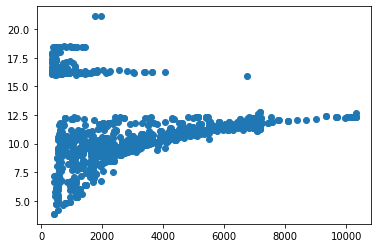

In [266]:
plt.scatter(df3p['Mass'], df3p['RT'])

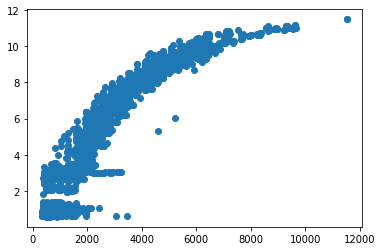

In [267]:
plt.scatter(df5p['Mass'], df5p['RT'])

In [4]:
# TAG = 826.3184
TAG = 694.2397
def init_df(df, tag=694.2397):
    df = df.append({'Mass': 18.0106, 'RT': 0.66, 'Vol': 10000}, ignore_index=True)
    df = df.append({'Mass': 347.0631, 'RT': 0.99, 'Vol': 10000}, ignore_index=True)
    df = df.append({'Mass': 323.0519, 'RT': 0.99, 'Vol': 10000}, ignore_index=True)
    df = df.append({'Mass': 363.058, 'RT': 0.99, 'Vol': 10000}, ignore_index=True)
    df = df.append({'Mass': 324.0359, 'RT': 0.99, 'Vol': 10000}, ignore_index=True)
    # df = df.append({'Mass': 826.3184, 'RT': 1.66, 'Vol': 20000}, ignore_index=True)
    df = df.append({'Mass': tag, 'RT': 1.66, 'Vol': 20000}, ignore_index=True)
    df.shape
    return df

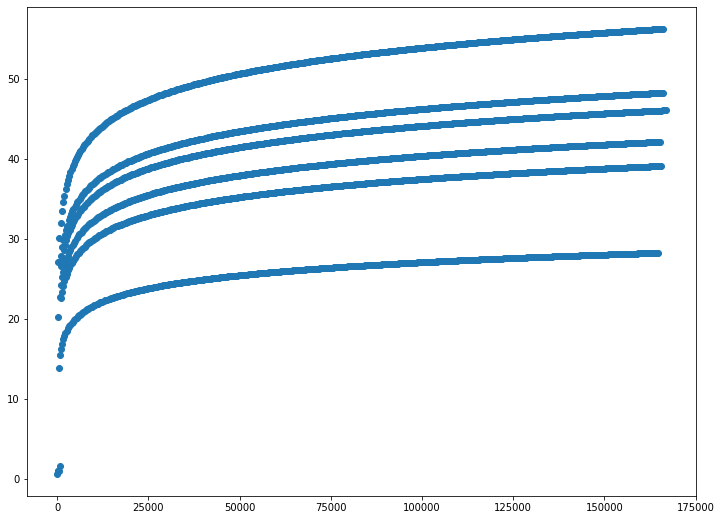

In [497]:
plt.figure(figsize=(12, 9))
plt.scatter(df['Mass'], df['RT'])

In [5]:
def base_calling_random(df):
    df = df.sort_index()
    mass_x = np.array(df.Mass)
    mass_y = np.array(df.Mass)
    print("mass_x {} mass_y {}".format(mass_x.shape, mass_y.shape))

    bases = [305.0413, 329.0525, 345.0474, 306.0253, 359.0631, 308.041, 319.0569, 320.041, 373.0787, 343.0682, 570.1475, 212.0086, 557.2251, 688.1156, 625.0844]
    base_dict = {'C': 305.0413, 'A': 329.0525, 'G': 345.0474, 'U': 306.0253, 'g': 359.0631, 'D': 308.041, 'c': 319.0569, 'T': 320.041, 'G^': 373.0787, 'a': 343.0682, 'y': 212.0086, 'Y': 570.1475, 'P': 557.2251, 'x': 688.1156, 'z': 625.0844}
    pairs = list()
    idxs = list()
    PPM = 10
    for k in base_dict.keys():
        base_mass = base_dict.get(k)
        ppm_matrix = np.abs((mass_x[:, np.newaxis] - mass_y - base_mass) * 1E6 / (mass_y + base_mass))
        ppm_df = pd.DataFrame(ppm_matrix)
        crosstalk = ppm_df[ppm_df < 10]
        idx_pairs = list(crosstalk[crosstalk.notnull()].stack().index)
        if idx_pairs:
            idx_pairs = [(*pair, k) for pair in idx_pairs] # append base name into idx_pairs
            pairs.extend(idx_pairs)
        df3_idxs = [pair[0] for pair in idx_pairs]
        df5_idxs = [pair[1] for pair in idx_pairs]
        df3_idxs = list(set(df3_idxs))
        df5_idxs = list(set(df5_idxs))
        print("df3_idxs {} df5_idxs {}".format(len(df3_idxs), len(df5_idxs)))
        idxs.extend(df3_idxs)
        idxs.extend(df5_idxs)
    
    mass_pairs = [(df.Mass.iloc[p[0]], df.Mass.iloc[p[1]], p[2]) for p in pairs]
    idxs = list(set(idxs))
    plt.figure(figsize=(16, 12))
    df_base_calling = df.iloc[idxs]
    print(df_base_calling.shape)
    return df_base_calling, mass_pairs

In [6]:
def get_end5p_points(df5p, sum_value):
    end_5p = sum_value - 80 - TAG
    masses = df5p.Mass
    print(end_5p)
    BIAS = 0.3
    end5p_idxs = masses[(masses>=end_5p-BIAS) & (masses<=end_5p+BIAS)].index
    print("end5p_idxs {}".format(end5p_idxs))
    
    endpoints = df5p.loc[end5p_idxs]
    endpoints = endpoints.sort_values('Vol', ascending=False)
    return endpoints.iloc[0]

# df5_idxs.extend(list(end5p_idxs))

In [7]:
def computational_data_seperation(df3p, df5p, full_mass, ignore_endpoints=False):
    df3p_mass_np = np.array(df3p['Mass'])
    df5p_mass_np = np.array(df5p['Mass'])
    mass_sum_np = df3p_mass_np[:, np.newaxis] + df5p_mass_np
    mass_sum_1 = np.round(mass_sum_np, 1)
    mass_sum_df = pd.DataFrame(mass_sum_np)
    mass_sum_df1 = pd.DataFrame(mass_sum_1)

    sum_value = round(full_mass + 18.0106, 1)

    tmp = mass_sum_df1[(mass_sum_df1 >= sum_value-0.1) & (mass_sum_df1 <= sum_value+0.1)]
    final_idx_pairs = list(tmp[tmp.notnull()].stack().index)
    df3_idxs = [pair[0] for pair in final_idx_pairs]
    df5_idxs = [pair[1] for pair in final_idx_pairs]
    df3_idxs = list(set(df3_idxs))
    df5_idxs = list(set(df5_idxs))
    print("df3_idxs {} df5_idxs {}".format(len(df3_idxs), len(df5_idxs)))

    df3p_selected = df3p.iloc[df3_idxs]
    df5p_selected = df5p.iloc[df5_idxs]
    
    if not ignore_endpoints:
        df5p_endpoints = get_end5p_points(df5p, full_mass + 18.0106)
        print("df5p_endpoints {}".format(df5p_endpoints[['Mass', 'RT', 'Vol']]))

        df3p_selected = df3p_selected.append(df5p_endpoints)
        df5p_selected = df5p_selected.append(df5p_endpoints)
        
    return df3p_selected, df5p_selected

In [8]:
def label_unlabel_comparison(df3p, df5p, diff=694.2397 + 61.9557):
    df3p_mass_np = np.array(df3p['Mass'])
    df5p_mass_np = np.array(df5p['Mass'])
    mass_sum_np = df3p_mass_np[:, np.newaxis] - df5p_mass_np
    mass_sum_1 = np.round(mass_sum_np, 1)
    mass_sum_df = pd.DataFrame(mass_sum_np)
    mass_sum_df1 = pd.DataFrame(mass_sum_1)

    comparee = round(diff, 1)

    tmp = mass_sum_df1[(mass_sum_df1 >= comparee-0.1) & (mass_sum_df1 <= comparee+0.1)]
    final_idx_pairs = list(tmp[tmp.notnull()].stack().index)
    df3_idxs = [pair[0] for pair in final_idx_pairs]
    df5_idxs = [pair[1] for pair in final_idx_pairs]
    df3_idxs = list(set(df3_idxs))
    df5_idxs = list(set(df5_idxs))
    print("df3_idxs {} df5_idxs {}".format(len(df3_idxs), len(df5_idxs)))

    df3p_selected = df3p.iloc[df3_idxs]
    df5p_selected = df5p.iloc[df5_idxs]
    return df3p_selected, df5p_selected

In [9]:
def plot_zones(df3p, df5p):
    plt.figure(figsize=(12, 9))
    sns.regplot(df3p.Mass, df3p.RT)
    sns.regplot(df5p.Mass, df5p.RT)

def plot_zone(df):
    plt.figure(figsize=(12, 9))
    plt.scatter(df.Mass, df.RT)

In [10]:
df3p = df
df5p = df
df3p.shape, df5p.shape

((38, 7), (38, 7))

In [733]:
src_to_transfer = '/Users/bryan/Downloads/gradientyeastsample4.xlsx'
df = pd.read_excel(src_to_transfer)
df.rename(columns={'Monoisotopic Mass': 'Mass', 'Sum Intensity': 'Vol', 'Apex RT': 'RT'}, inplace=True)
df.to_excel(src_to_transfer)

In [11]:
df = pd.read_excel('/Users/bryan/Downloads/oligosdegradsample2.xlsx')
df.shape

(1386, 14)

In [12]:
df_big = df[df.Mass>22000].sort_values('Vol', ascending=False)[:10][['Mass', 'Vol', 'RT']]
df_big

,Mass,Vol,RT
1363,24252.354538,36982472.75,3.844311
1369,24581.417714,21547144.54,3.884637
1365,24280.354981,6036971.94,3.859285
1364,24267.345632,5551185.07,3.844311
1371,24609.413063,3170775.70,3.884637
1370,24596.389890,3084010.49,3.884637
1366,24309.354098,1460313.21,3.859285
1367,24331.331703,1259745.41,3.884637
1361,24027.301692,1083931.98,3.884637
1377,25334.637863,1082678.51,4.082539


In [13]:
# full_mass = 24581.37038 # phe
# full_mass = 24252.354538 # phe2
# full_mass = 24233.17434 # Asp
# full_mass = 24287.342597 # unknow
full_mass = df_big.iloc[1].Mass
print(full_mass)
df_ms, _ = computational_data_seperation(df, df, full_mass=full_mass, ignore_endpoints=True)
df_ms.shape

24581.417713682
df3_idxs 76 df5_idxs 76


(76, 14)

In [14]:
df_ms_bcr, mass_pairs = base_calling_random(df_ms)
df_ms_bcr.shape, len(mass_pairs)

mass_x (76,) mass_y (76,)
df3_idxs 6 df5_idxs 6
df3_idxs 16 df5_idxs 16
df3_idxs 16 df5_idxs 16
df3_idxs 12 df5_idxs 12
df3_idxs 2 df5_idxs 2
df3_idxs 1 df5_idxs 1
df3_idxs 4 df5_idxs 4
df3_idxs 2 df5_idxs 2
df3_idxs 0 df5_idxs 0
df3_idxs 1 df5_idxs 1
df3_idxs 2 df5_idxs 2
df3_idxs 0 df5_idxs 0
df3_idxs 0 df5_idxs 0
df3_idxs 2 df5_idxs 2
df3_idxs 8 df5_idxs 8
(72, 14)


((72, 14), 72)

<Figure size 1152x864 with 0 Axes>

In [17]:
df_ms_bcr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 542 to 1356
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    72 non-null     int64  
 1   Mass                          72 non-null     float64
 2   Average Mass                  72 non-null     float64
 3   Vol                           72 non-null     float64
 4   Relative Abundance            72 non-null     float64
 5   Fractional Abundance          72 non-null     float64
 6   Number of Charge States       72 non-null     int64  
 7   Charge State Distribution     72 non-null     object 
 8   Number of Detected Intervals  72 non-null     int64  
 9   Delta Mass                    72 non-null     float64
 10  Scan Range                    72 non-null     object 
 11  Start Time (min)              72 non-null     float64
 12  Stop Time (min)               72 non-null     float64
 13  RT 

count 72 idx 72
s C xy(5349.80422057473 2.30001015818914)
count 72 idx 71
s C xy(6648.99502912527 2.56274644093514)
count 72 idx 70
s C xy(9201.31391108018 3.02323255098661)
count 72 idx 69
s C xy(15703.1751674768 3.68059478359222)
count 72 idx 68
s C xy(18255.4866691479 3.76370479222933)
count 72 idx 67
s C xy(19554.6935397081 3.76370479222933)
count 72 idx 66
s A xy(4618.57837363944 2.31909729199409)
count 72 idx 65
s A xy(6943.90966020169 2.87449998415311)
count 72 idx 64
s A xy(7618.00620684439 3.00042453365326)
count 72 idx 63
s A xy(9580.3226500352 3.26019419388771)
count 72 idx 62
s A xy(10254.4203163409 3.31604103601774)
count 72 idx 61
s A xy(10540.511491454 3.16090868469874)
count 72 idx 60
s A xy(11896.6718285777 3.50088411725362)
count 72 idx 59
s A xy(12437.7371120495 3.54286828395526)
count 72 idx 58
s A xy(12490.7889810357 3.31604103601774)
count 72 idx 57
s A xy(13031.8611508165 3.38437517639796)
count 72 idx 56
s A xy(14387.9863122286 3.63811352607409)
count 72 idx 55


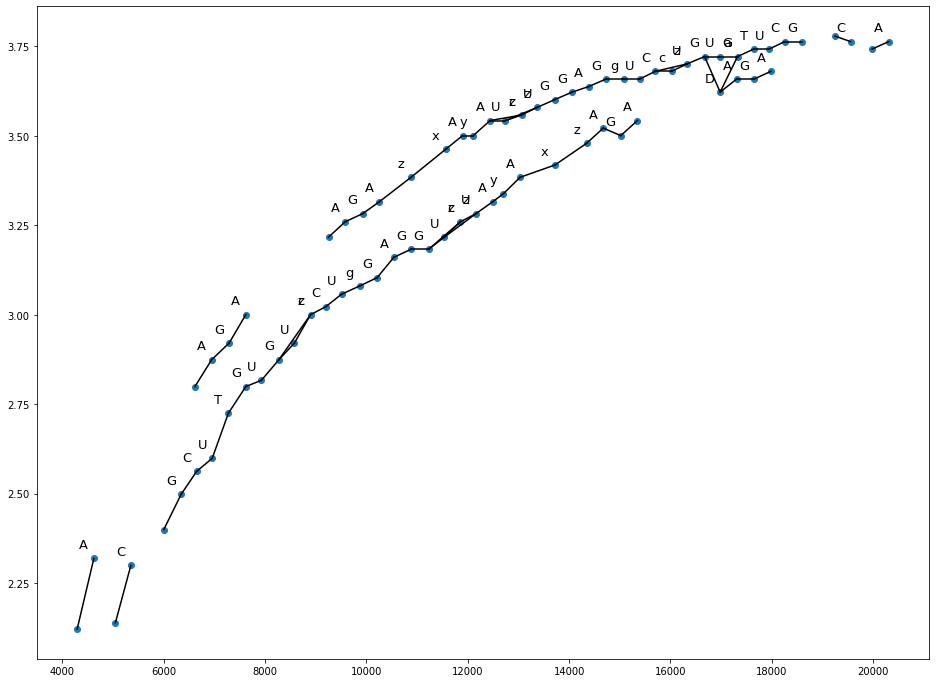

In [16]:
%run ../modules/utils.ipynb
plot_basecalling2(df_ms_bcr, mass_pairs)

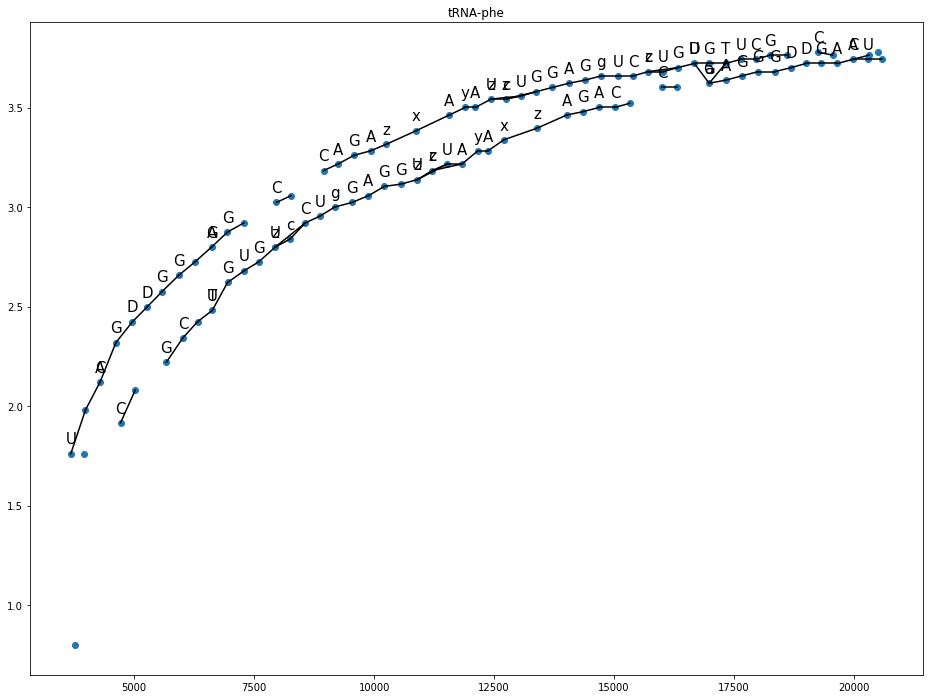

In [820]:
plt.figure(figsize=(16, 12))
plt.scatter(df_ms.Mass, df_ms.RT)
mass1 = [t[0] for t in mass_pairs]
mass2 = [t[1] for t in mass_pairs]

for t in mass_pairs:
    df_pair = df_ms[df_ms.Mass.isin(t)]
#     print("p1 {} p2 {}".format(p1.Mass.values[0], p2.Mass))
    plt.plot(df_pair.Mass, df_pair.RT, 'black')
    plt.annotate(s=t[2], size=15, xy=(df_pair.Mass[:1], df_pair.RT[:1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('tRNA-phe')
plt.show()

In [530]:
df = df.sort_values('Vol', ascending=False)

In [534]:
df.iloc[:5][['Mass', 'Vol']]

,Mass,Vol
58,620.339030,5.634191
145,737.951998,3.001193
4298,23545.168802,1.793130
27,587.960901,1.439100
4301,23599.180604,0.904771


In [486]:
df = pd.read_excel('/Users/bryan/Studio/seq_bank/694.2397_500_20200624112302.xlsx')
df.shape

(3000, 7)

In [536]:
df1 = pd.read_excel('/Users/bryan/Documents/SeqDataSets/PaperData/ACS/100918s06.xls')
df2 = pd.read_excel('/Users/bryan/Downloads/oligosdegradsample2.xlsx')
df1.shape, df2.shape

((4589, 26), (1386, 14))

In [511]:
df1.columns, df2.columns

(Index(['Cpd', 'Show/Hide', 'm/z', 'Max Z', 'Min Z', 'Mass', 'Avg Mass', 'RT',
        'Vol', 'Quality Score', 'Label', 'Std Dev', 'Base Peak', 'Polarity',
        'Start', 'End', 'Height', 'Width', 'Vol %', 'Ions', 'Z Count',
        'Saturated', 'Group', 'Cpds/Group', 'File', 'Algorithm'],
       dtype='object'),
 Index(['Unnamed: 0', 'Mass', 'Average Mass', 'Sum Intensity',
        'Relative Abundance', 'Vol', 'Number of Charge States',
        'Charge State Distribution', 'Number of Detected Intervals',
        'Delta Mass', 'Scan Range', 'Start Time (min)', 'Stop Time (min)',
        'RT'],
       dtype='object'))

In [512]:
df_phe = pd.concat([df1[['Mass', 'RT', 'Vol']], df2[['Mass', 'RT', 'Vol']]])

In [574]:
df_ms.to_excel('data/asp_merge.xlsx')

In [440]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [453]:
df.shape

(1386, 13)

In [441]:
df.head()

,Mass,Average Mass,Sum Intensity,Relative Abundance,Vol,Number of Charge States,Charge State Distribution,Number of Detected Intervals,Delta Mass,Scan Range,Start Time (min),Stop Time (min),RT
0,2773.421582,2774.711699,1470029.78,3.974936,0.287581,4,2 - 5,6,0.000000,25 - 39,0.360320,0.533928,0.418643
1,2801.414056,2802.716874,65458.05,0.176997,0.012806,4,2 - 5,3,27.992474,30 - 39,0.420355,0.533928,0.482580
2,2815.353014,2816.662118,369067.52,0.997953,0.072201,4,2 - 5,6,41.931433,37 - 51,0.499843,0.680516,0.599129
3,2826.411374,2827.725446,122653.18,0.331652,0.023995,4,2 - 5,6,52.989792,49 - 62,0.640224,0.823725,0.720407
4,2833.320534,2834.637703,319637.04,0.864293,0.062530,4,2 - 5,5,59.898953,35 - 48,0.478330,0.640224,0.561981


In [506]:
def computational_data_seperation(df3p, df5p, full_mass, ignore_endpoints=False):
    df3p_mass_np = np.array(df3p['Mass'])
    df5p_mass_np = np.array(df5p['Mass'])
    mass_sum_np = df3p_mass_np[:, np.newaxis] + df5p_mass_np
    mass_sum_1 = np.round(mass_sum_np, 1)
    mass_sum_df = pd.DataFrame(mass_sum_np)
    mass_sum_df1 = pd.DataFrame(mass_sum_1)

    sum_value = round(full_mass + 18.0106, 1)

    bias = 0.2
    tmp = mass_sum_df1[(mass_sum_df1 >= sum_value-bias) & (mass_sum_df1 <= sum_value+bias)]
    final_idx_pairs = list(tmp[tmp.notnull()].stack().index)
    df3_idxs = [pair[0] for pair in final_idx_pairs]
    df5_idxs = [pair[1] for pair in final_idx_pairs]
    df3_idxs = list(set(df3_idxs))
    df5_idxs = list(set(df5_idxs))
    print("df3_idxs {} df5_idxs {}".format(len(df3_idxs), len(df5_idxs)))

    df3p_selected = df3p.iloc[df3_idxs]
    df5p_selected = df5p.iloc[df5_idxs]
    
    if not ignore_endpoints:
        df5p_endpoints = get_end5p_points(df5p, full_mass + 18.0106)
        print("df5p_endpoints {}".format(df5p_endpoints[['Mass', 'RT', 'Vol']]))

        df3p_selected = df3p_selected.append(df5p_endpoints)
        df5p_selected = df5p_selected.append(df5p_endpoints)
        
    return df3p_selected, df5p_selected

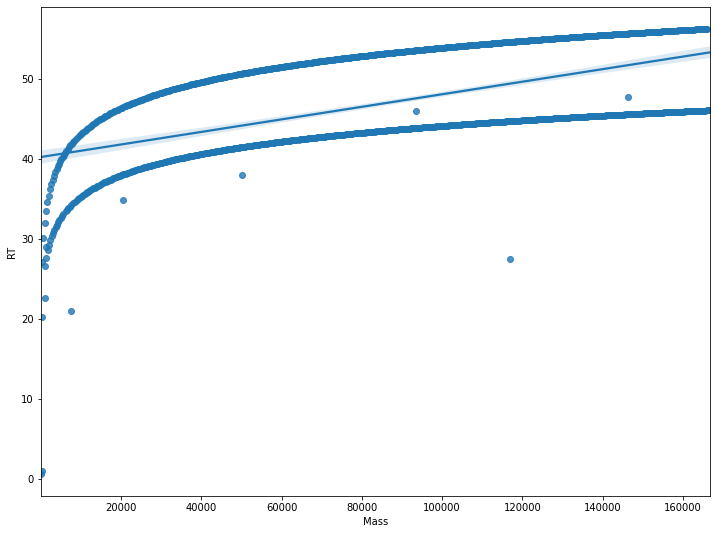

In [509]:
plot_zone(df3p)

In [537]:
#24581.37038
full_mass = 24581.37038
df_ms, _ = computational_data_seperation(df2, df2, full_mass=full_mass, ignore_endpoints=True)

df3_idxs 76 df5_idxs 76


In [540]:
df2.columns

Index(['Unnamed: 0', 'Mass', 'Average Mass', 'Sum Intensity',
       'Relative Abundance', 'Vol', 'Number of Charge States',
       'Charge State Distribution', 'Number of Detected Intervals',
       'Delta Mass', 'Scan Range', 'Start Time (min)', 'Stop Time (min)',
       'RT'],
      dtype='object')

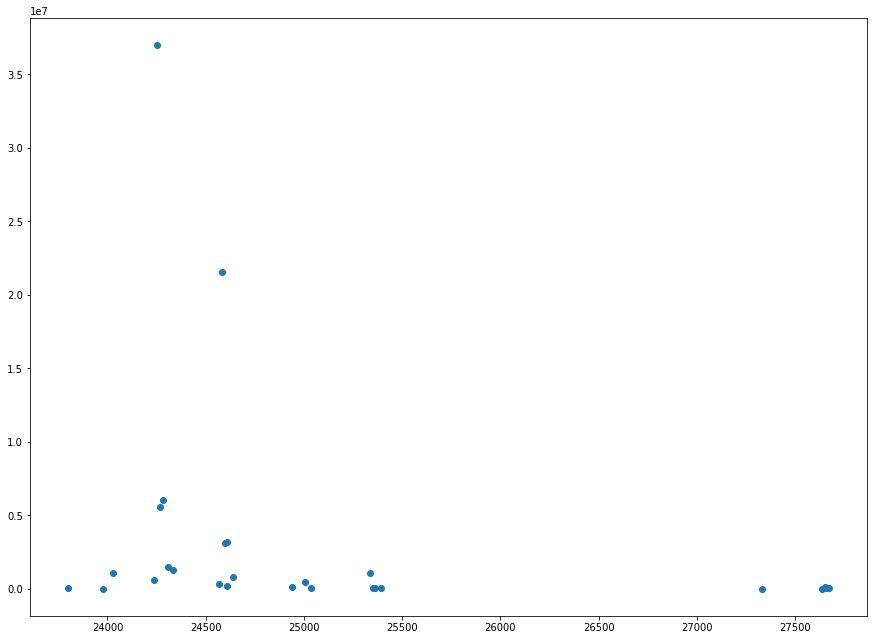

In [547]:
plt.figure(figsize=(15,11))
plt.scatter(df2[df2.Mass > 22000].Mass, df2[df2.Mass > 22000]['Sum Intensity'])

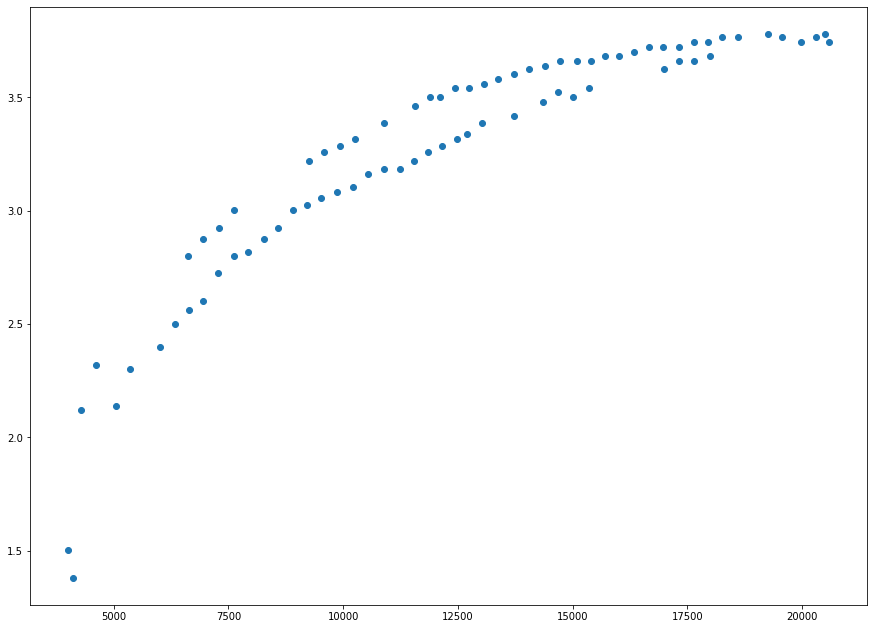

In [539]:
plt.figure(figsize=(15, 11))
plt.scatter(df_ms.Mass, df_ms.RT)

In [508]:
df3p.to_excel('data/tmp_mix500.xlsx')

In [435]:
full_masses = {'19': 6781.0752, '20': 7079.0804, '21': 7522.1083, '201': 7088.0843, '202': 6985.0440, 
               '203': 7073.0746, '204': 6954.9496, '205': 7110.0903, '206': 7151.1211, '207': 7193.0484}
for k in full_masses.keys():
    full_mass = full_masses.get(k)
    df_seq, _ = computational_data_seperation(df3p, df5p, full_mass=full_mass)
    df_seq.to_excel('data/merge/mix_{}_{}.xlsx'.format(len(full_masses), k))
    df_seq.shape
#     plot_zone(df_seq)

df3_idxs 3567 df5_idxs 3567
6024.8461
end5p_idxs Int64Index([2, 292, 4125], dtype='int64')
df5p_endpoints Mass    6.024848e+03
RT      7.743000e+00
Vol     1.374014e+07
Name: 2, dtype: float64
df3_idxs 3103 df5_idxs 3103
6322.851299999999
end5p_idxs Int64Index([511], dtype='int64')
df5p_endpoints Mass    6.322856e+03
RT      7.741000e+00
Vol     1.369573e+07
Name: 511, dtype: float64
df3_idxs 4900 df5_idxs 4900
6765.879199999999
end5p_idxs Int64Index([1445], dtype='int64')
df5p_endpoints Mass    6.765874e+03
RT      7.858000e+00
Vol     8.310886e+06
Name: 1445, dtype: float64
df3_idxs 2952 df5_idxs 2952
6331.8552
end5p_idxs Int64Index([2817, 2890, 4070], dtype='int64')
df5p_endpoints Mass    6.331858e+03
RT      8.134000e+00
Vol     2.771455e+07
Name: 2817, dtype: float64
df3_idxs 2774 df5_idxs 2774
6228.814899999999
end5p_idxs Int64Index([4094, 4095], dtype='int64')
df5p_endpoints Mass    6.228829e+03
RT      9.631000e+00
Vol     7.682414e+07
Name: 4094, dtype: float64
df3_idxs 3004 d

In [811]:
# full_mass = 6847.0787
# full_mass = 6929.0318
full_mass = 6781.0752 #19
# full_mass = 7079.0804 #20
# full_mass = 7522.1083 #21
# full_mass = 7088.0843 #201
# full_mass = 6985.0440 #202
# full_mass = 7073.0746 #203
# full_mass = 6954.9496 #6954.9868 #204
# full_mass = 7110.0903 #205
# full_mass = 7151.1211 #206
# full_mass = 7193.0484 #207


In [813]:
df = pd.read_csv('/Users/bryan/Documents/SeqDataSets/2mix/NZ_180521s07_19_20.csv')
print(df.shape)
df = init_df(df)
df3p = df5p = df
df_seq, _ = computational_data_seperation(df3p, df5p, full_mass=full_mass)
# df_seq.to_excel('data/merge_pure/mix_1_19.xlsx')
df_seq.shape
plot_zone(df_seq)

(1112, 57)


In [281]:
df_3p, df_5p = computational_data_seperation(df3p, df5p, full_mass=full_mass)
df_3p.shape, df_5p.shape

df3_idxs 98 df5_idxs 98
6024.8461
end5p_idxs Int64Index([384], dtype='int64')
df5p_endpoints Mass       6024.85
RT           7.575
Vol     3.2328e+07
Name: 384, dtype: object


((99, 38), (99, 38))

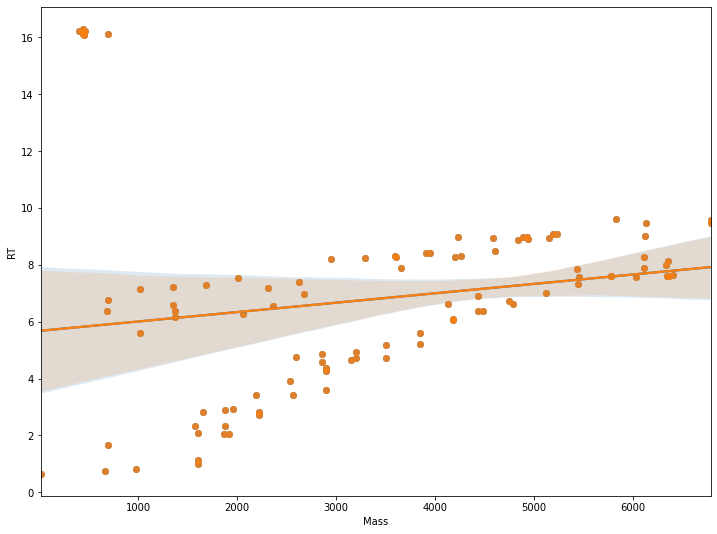

In [282]:
plot_zones(df_3p, df_5p)

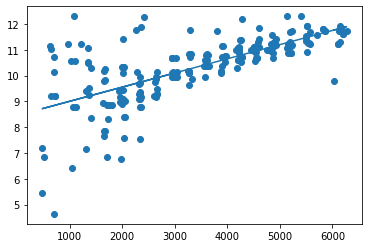

In [271]:
df_seq = df_seq[df_seq.RT < 15]
z = np.polyfit(df_seq.Mass, df_seq.RT, 1)
def f(x):
    return z[0]*x + z[1]
plt.scatter(df_seq.Mass, df_seq.RT)
plt.plot(df_seq.Mass, f(df_seq.Mass))

In [117]:
# df_seq_3p = df_seq[df_seq.RT > f(df_seq.Mass)]
# df_seq_5p = df_seq[df_seq.RT <= f(df_seq.Mass)]
df_seq_3p.shape, df_seq_5p.shape

((37, 39), (51, 39))

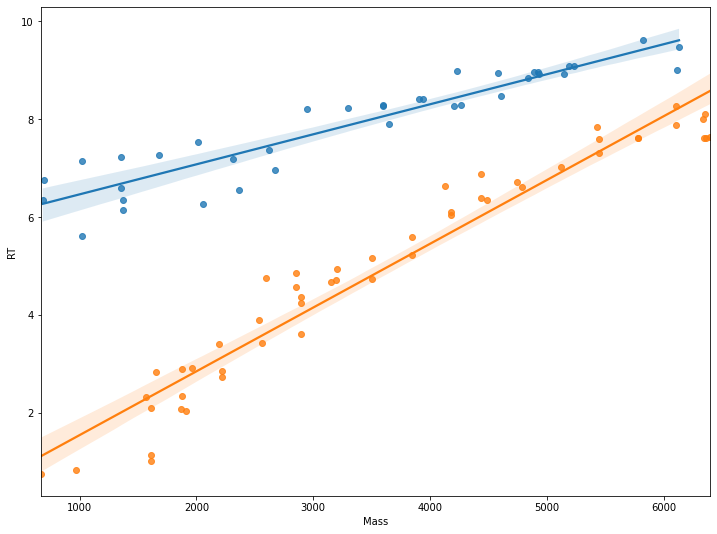

In [116]:
plot_zones(df_seq_3p, df_seq_5p)

In [118]:
df_label, df_unlabel = label_unlabel_comparison(df3p, df5p)

df3_idxs 161 df5_idxs 187


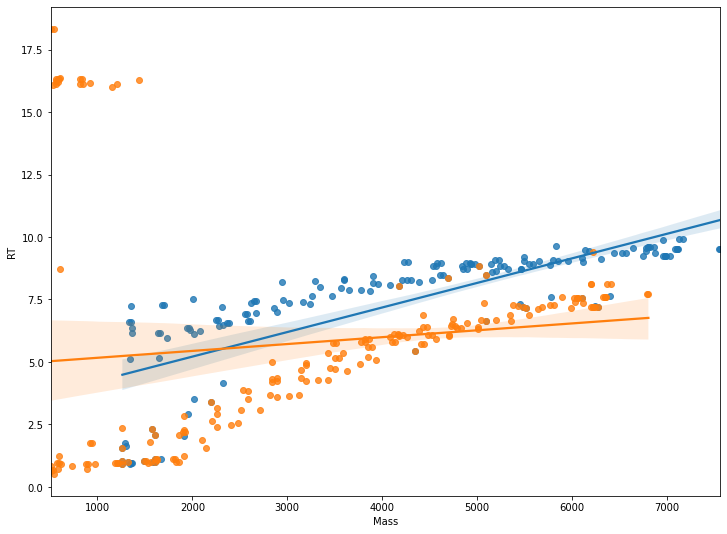

In [119]:
plot_zones(df_label, df_unlabel)

In [120]:
df_common_3p = pd.merge(df_label, df_seq_3p, how='inner')
df_common_3p.shape

(31, 39)

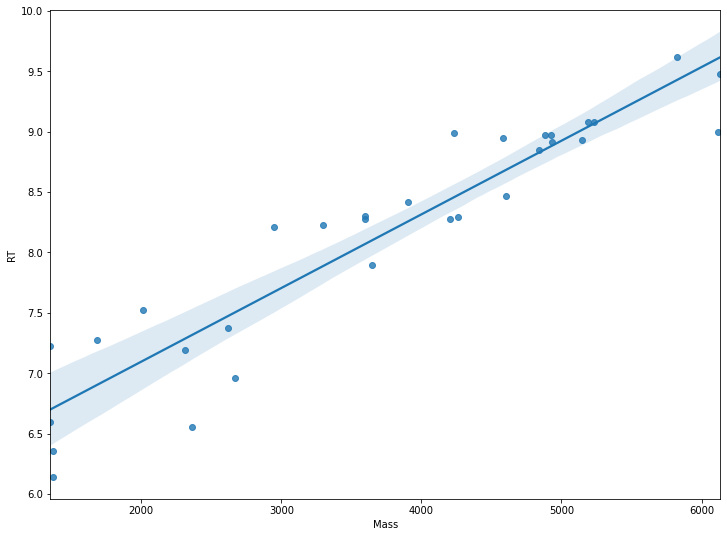

In [121]:
plot_zone(df_common_3p)

In [241]:
df_common_3p_bc = base_calling_random(df_common_3p)
df_common_3p_bc.shape

NameError: name 'df_common_3p' is not defined

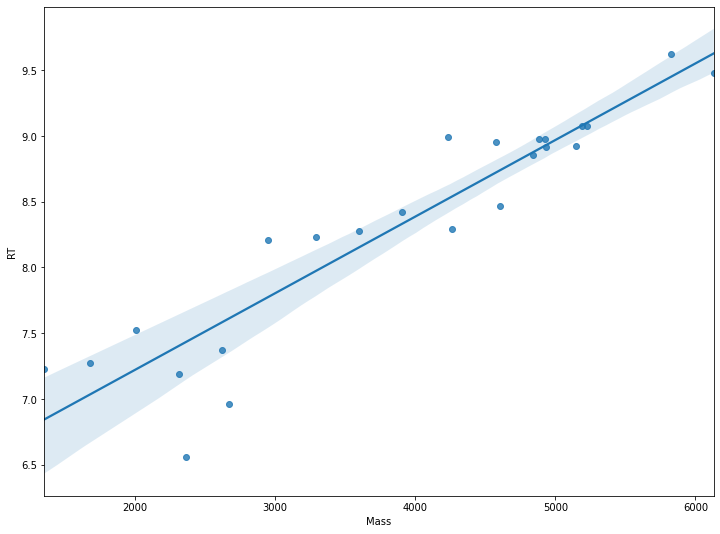

In [124]:
plot_zone(df_common_3p_bc)

In [125]:
df_common_3p_lbl, df_unlbl = label_unlabel_comparison(df_common_3p, df_unlabel)

df3_idxs 31 df5_idxs 42


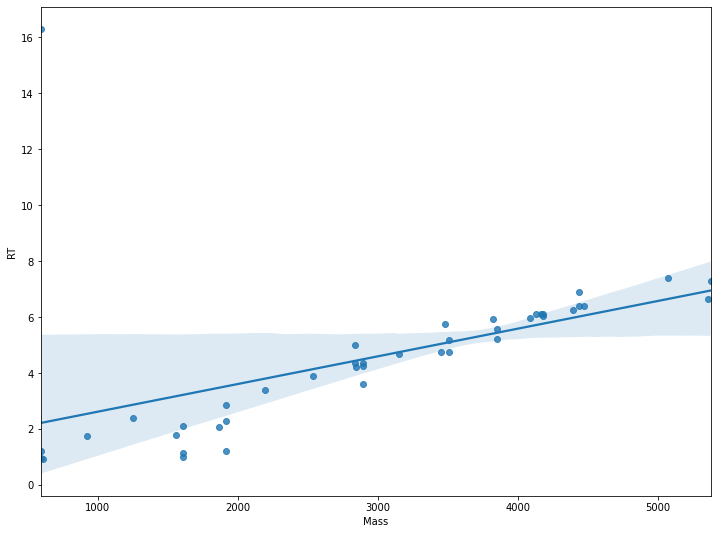

In [126]:
plot_zone(df_unlbl)

In [127]:
df_unlbl_bc = base_calling_random(df_unlbl)
df_unlbl_bc.shape

mass_x (42,) mass_y (42,)
df3_idxs 6 df5_idxs 6
df3_idxs 6 df5_idxs 6
df3_idxs 4 df5_idxs 4
df3_idxs 6 df5_idxs 6
df3_idxs 0 df5_idxs 0
df3_idxs 0 df5_idxs 0
df3_idxs 0 df5_idxs 0
df3_idxs 0 df5_idxs 0
df3_idxs 0 df5_idxs 0
df3_idxs 0 df5_idxs 0
df3_idxs 0 df5_idxs 0
df3_idxs 0 df5_idxs 0
df3_idxs 0 df5_idxs 0
df3_idxs 0 df5_idxs 0
df3_idxs 1 df5_idxs 1
(31, 39)


(31, 39)

<Figure size 1152x864 with 0 Axes>

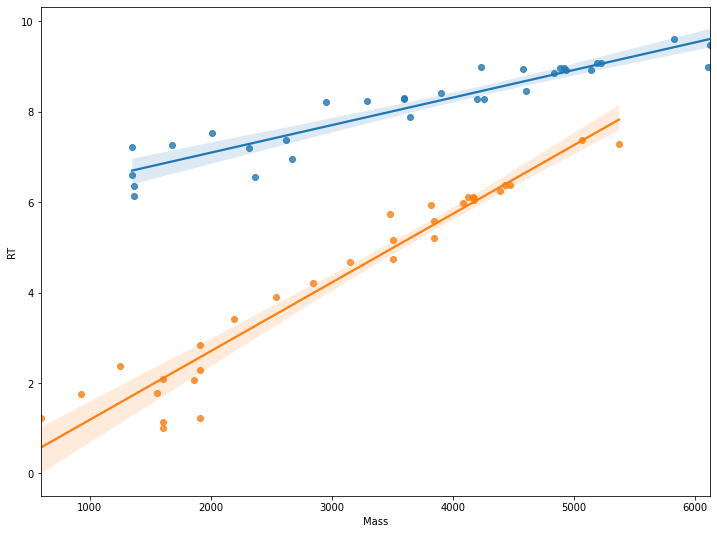

In [129]:
plot_zones(df_common_3p_lbl, df_unlbl_bc)

In [132]:
df_common_3p_tmp, df_seq_5p_tmp = computational_data_seperation(df_common_3p, df_seq_5p)

df3_idxs 30 df5_idxs 39


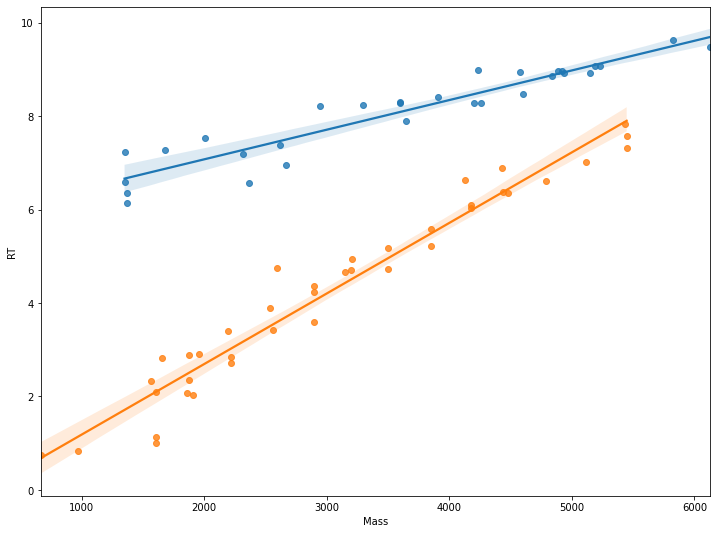

In [133]:
plot_zones(df_common_3p_tmp, df_seq_5p_tmp)

In [137]:
df_common_3p_tmp[['Mass', 'RT', 'Vol', 'Quality Score']]

,Mass,RT,Vol,Quality Score
0,1368.3337,6.357,200383,100.0
1,1368.3336,6.145,362704,100.0
2,5825.9173,9.621,331260,80.0
3,6130.9611,9.479,366257,80.0
4,5228.7845,9.079,290290,80.0
5,5190.8448,9.079,1075639,100.0
7,4234.7306,8.989,1126279,100.0
8,4885.7985,8.975,1101382,100.0
9,4923.7423,8.974,241030,80.0
10,4579.7768,8.951,1160905,80.0


In [134]:
df_common_3p_lbl.to_excel('data/19_3p.xls')
df_seq_5p_tmp.to_excel('data/19_5p.xls')

In [ ]:
# df = df.sort_values(by='Vol', ascending=False)
df = df.sort_index()
df.to_csv('data/5p.csv')

In [8]:
df3p_mass_np = np.array(df3p['Mass'])
df5p_mass_np = np.array(df5p['Mass'])
mass_sum_np = df3p_mass_np[:, np.newaxis] + df5p_mass_np

In [9]:
mass_sum_0 = np.round(mass_sum_np, 0)
mass_sum_1 = np.round(mass_sum_np, 1)
mass_sum_2 = np.round(mass_sum_np, 2)
mass_sum_3 = np.round(mass_sum_np, 3)

In [10]:
# seq_mass = 7281.1982
# seq_mass = 7079.0861
seq_mass = 6781.0487 #6781.0763
# seq_mass = 7522.1079
# seq_mass = 7088.0775
# seq_mass = 7073.0735
# seq_mass = 6954.9831
# seq_mass = 7110.0883
# seq_mass = 7151.113
# seq_mass = 7193.0523
# seq_mass = 6781.0763
# seq_mass = 6985.9879
sum_value = round(seq_mass + 18.0106, 1)
mass_sum_1[(mass_sum_1 >= sum_value-0.2) & (mass_sum_1 <=sum_value+0.2)]

array([6799. , 6799. , 6799.1, 6799. , 6799.1, 6799. , 6799. , 6799. ,
       6799. , 6799.1, 6799.1, 6799.1, 6799.1, 6799.3, 6799.1, 6799.1,
       6799. , 6799. , 6799.1, 6799. , 6799. , 6799. , 6799. , 6799.1,
       6799. , 6799.1, 6799. , 6799. , 6799. , 6799.1, 6799. , 6799.1,
       6799. , 6799.1, 6799.1, 6799. , 6799. , 6799. , 6799.1, 6799.1,
       6799.1, 6799.1, 6799.1, 6799.1, 6799.1, 6799.1, 6799.1, 6799.1,
       6799.1, 6799.1, 6799.1, 6799. , 6799. , 6799. , 6799. , 6799. ,
       6799. , 6799.1, 6799. , 6799. , 6799.1, 6799.1, 6799. , 6799.1,
       6799. , 6799. , 6799.1, 6799. , 6799. , 6799. , 6799. , 6799.1,
       6799. , 6799.2, 6799. , 6799. , 6799.1, 6799. , 6799. , 6799. ,
       6799. , 6799. , 6799.2, 6799.2, 6799.1, 6799. , 6799. , 6799. ,
       6799.1, 6799.1, 6799. , 6799. , 6799.1, 6799.1, 6799.1, 6799. ,
       6799.1, 6799.1, 6799.1, 6799.1, 6799.1, 6799.1, 6799.1, 6799.1,
       6799. , 6799. , 6799. , 6799. , 6799. , 6799. , 6799. , 6799.1,
      

In [13]:
end_5p = sum_value - 80 - TAG
masses = df5p.Mass
print(end_5p)
BIAS = 0.1
end5p_idxs = masses[(masses>=end_5p-BIAS) & (masses<=end_5p+BIAS)].index
df5p.loc[end5p_idxs]

6024.8603


,Unnamed: 0,Cpd,Mass,m/z,Show/Hide,Label,Avg Mass,Std Dev,Base Peak,Polarity,...,Vol,Vol %,Ions,Z Count,Saturated,Group,Cpds/Group,File,Algorithm,Quality Score
6,11,2707,6024.8560,668.4214,True,Cpd 2707: 9.786,6027.8712,0.0034,668.6429,Negative,...,28678592,1.23,99,9,NaN,538,13,NZ_180830_s33.d,Find by Molecular Feature,100.0
237,313,2619,6024.8512,601.4784,True,Cpd 2619: 9.610,6028.3743,0.0268,601.6789,Negative,...,1352183,0.06,34,5,NaN,524,20,NZ_180830_s33.d,Find by Molecular Feature,87.0


In [14]:
# tmp = mass_sum_1[((mass_sum_1 >= sum_value-0.1) & (mass_sum_1 <= sum_value+0.1)) | ((mass_sum_1 >= sum_value-80-0.1) & (mass_sum_1 <= sum_value-80+0.1))]
tmp = mass_sum_1[(mass_sum_1 >= sum_value-0.1) & (mass_sum_1 <= sum_value+0.1)]
len(tmp)

412

In [15]:
mass_sum_df = pd.DataFrame(mass_sum_np)
mass_sum_df1 = pd.DataFrame(mass_sum_1)

# tmp = mass_sum_df1[((mass_sum_df1 >= sum_value-0.1) & (mass_sum_df1 <= sum_value+0.1)) | ((mass_sum_df1 >= sum_value-80-0.1) & (mass_sum_df1 <= sum_value-80+0.1))]
tmp = mass_sum_df1[(mass_sum_df1 >= sum_value-0.1) & (mass_sum_df1 <= sum_value+0.1)]
final_idx_pairs = list(tmp[tmp.notnull()].stack().index)
df3_idxs = [pair[0] for pair in final_idx_pairs]
df5_idxs = [pair[1] for pair in final_idx_pairs]
# df5_idxs += df3_idxs
# print("df3 idxs {} \ndf5 idxs {}".format(df3_idxs, df5_idxs))

# df3p_mass_np[df3_idxs]
# df5p_mass_np[df5_idxs]
print("df3_idxs {} df5_idxs {}".format(len(df3_idxs), len(df5_idxs)))

df3_idxs 412 df5_idxs 412


In [16]:
df3_idxs_tmp = list(set(df3_idxs))
len(df3_idxs_tmp)

304

In [17]:
df3_idxs = list(set(df3_idxs))
df5_idxs = list(set(df5_idxs))
df5_idxs.extend(list(end5p_idxs))
print(len(df5_idxs))

335


(335, 27) (304, 27)


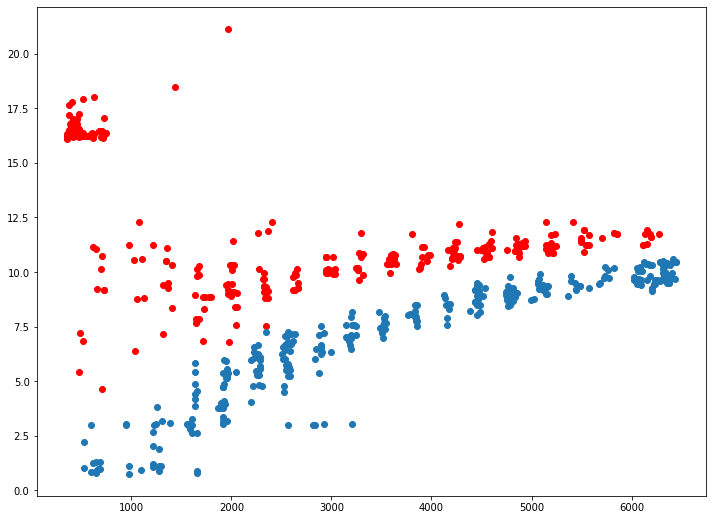

In [18]:
plt.figure(figsize=(12, 9))
df3p_selected = df3p.iloc[df3_idxs]
df5p_selected = df5p.iloc[df5_idxs]
print(df5p_selected.shape, df3p_selected.shape)
df5p_selected = df5p_selected.sort_values('Mass')
plt.scatter(df3p_selected['Mass'], df3p_selected['RT'], color='r')
plt.scatter(df5p_selected['Mass'], df5p_selected['RT'])

In [20]:
df3p_selected = df3p_selected.sort_values('Vol', ascending=False)

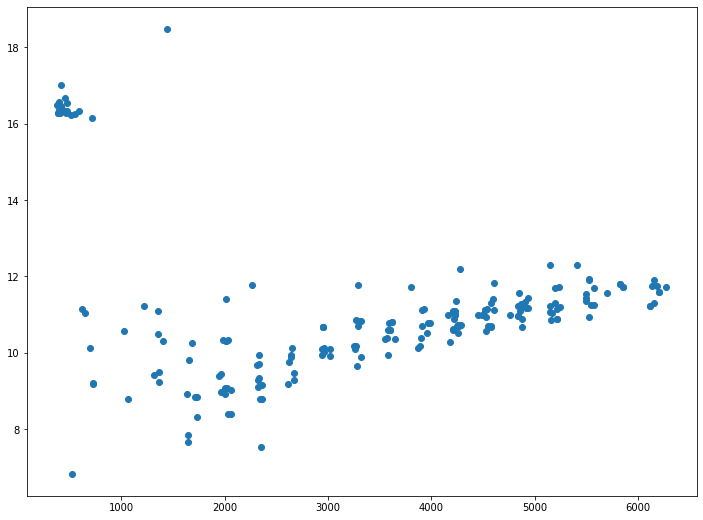

In [22]:
df3p_top = df3p_selected.iloc[:200]
plt.figure(figsize=(12, 9))
plt.scatter(df3p_top.Mass, df3p_top.RT)

In [24]:
df3p_basecalling = base_calling_random(df3p_selected)

mass_x (304,) mass_y (304,)
df3_idxs 32 df5_idxs 30
df3_idxs 52 df5_idxs 50
df3_idxs 29 df5_idxs 26
df3_idxs 33 df5_idxs 37
df3_idxs 6 df5_idxs 5
df3_idxs 5 df5_idxs 5
df3_idxs 6 df5_idxs 6
df3_idxs 9 df5_idxs 9
df3_idxs 3 df5_idxs 3
df3_idxs 2 df5_idxs 2
df3_idxs 3 df5_idxs 3
df3_idxs 3 df5_idxs 4
df3_idxs 0 df5_idxs 0
df3_idxs 2 df5_idxs 2
df3_idxs 10 df5_idxs 12
(173, 27)


<Figure size 1152x864 with 0 Axes>

In [32]:
df5p_basecalling = base_calling_random(df5p_selected)

mass_x (335,) mass_y (335,)
df3_idxs 49 df5_idxs 48
df3_idxs 55 df5_idxs 56
df3_idxs 31 df5_idxs 30
df3_idxs 45 df5_idxs 47
df3_idxs 9 df5_idxs 9
df3_idxs 14 df5_idxs 14
df3_idxs 6 df5_idxs 7
df3_idxs 20 df5_idxs 22
df3_idxs 8 df5_idxs 7
df3_idxs 9 df5_idxs 8
df3_idxs 6 df5_idxs 7
df3_idxs 6 df5_idxs 4
df3_idxs 0 df5_idxs 0
df3_idxs 6 df5_idxs 6
df3_idxs 18 df5_idxs 22
(258, 27)


<Figure size 1152x864 with 0 Axes>

In [36]:
df3p_selected.to_excel('data/first.xlsx')

In [35]:
df3p_cds, df5p_cds = computational_data_seperation(df3p_basecalling, df5p_basecalling)

df3_idxs 163 df5_idxs 210


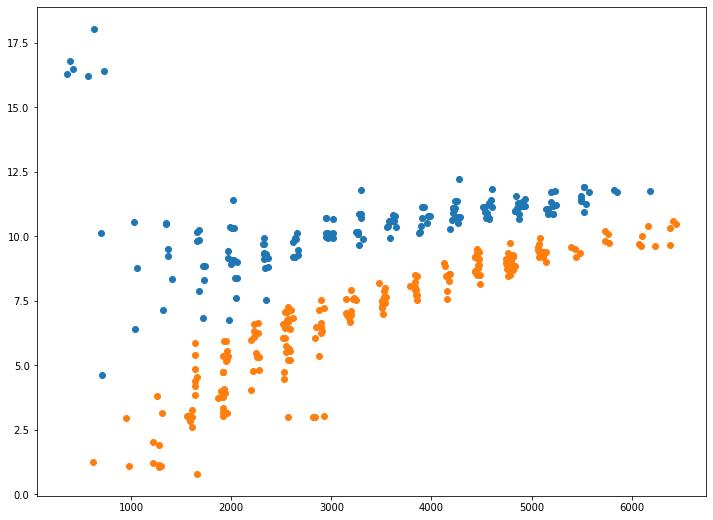

In [37]:
plot_zones(df3p_cds, df5p_cds)

In [38]:
df3p_cds = base_calling_random(df3p_cds)
df5p_cds = base_calling_random(df5p_cds)

mass_x (163,) mass_y (163,)
df3_idxs 32 df5_idxs 30
df3_idxs 49 df5_idxs 48
df3_idxs 27 df5_idxs 24
df3_idxs 33 df5_idxs 37
df3_idxs 5 df5_idxs 4
df3_idxs 5 df5_idxs 5
df3_idxs 5 df5_idxs 5
df3_idxs 8 df5_idxs 8
df3_idxs 3 df5_idxs 3
df3_idxs 2 df5_idxs 2
df3_idxs 2 df5_idxs 2
df3_idxs 1 df5_idxs 1
df3_idxs 0 df5_idxs 0
df3_idxs 1 df5_idxs 1
df3_idxs 9 df5_idxs 10
(162, 27)
mass_x (210,) mass_y (210,)
df3_idxs 46 df5_idxs 43
df3_idxs 54 df5_idxs 54
df3_idxs 30 df5_idxs 29
df3_idxs 42 df5_idxs 44
df3_idxs 4 df5_idxs 4
df3_idxs 9 df5_idxs 9
df3_idxs 5 df5_idxs 5
df3_idxs 11 df5_idxs 14
df3_idxs 4 df5_idxs 3
df3_idxs 8 df5_idxs 7
df3_idxs 3 df5_idxs 2
df3_idxs 1 df5_idxs 1
df3_idxs 0 df5_idxs 0
df3_idxs 1 df5_idxs 1
df3_idxs 14 df5_idxs 18
(209, 27)


<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>